# Pair-wise image order Learning with Siamese Networks



In [18]:
%matplotlib inline
import os
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import logging
from tqdm import tqdm
import time

Helper functions

In [19]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Configuration Class

In [20]:
class Config():
    imageFiles_path = {}
    imageFiles_path['train'] = "../shared_data/train_images/"
    imageFiles_path['test'] =  "../shared_data/val_images/"
    #train/test split info
    movie_names = {}        
    movie_names['train'] = np.load("../shared_data/train_vids.npy")
    movie_names['test'] =  np.load("../shared_data/test_vids.npy")
    
    train_batch_size = 32
    test_batch_size = 32


# Data Preparation

In [22]:
'''
input:
- video2cnames = {
                    '-9GYpCvGIgM':[clip_name1, clip_name2, …], 
                    ……
                  }
- gap: the interval step num between image pairs

output:
- data: save img pairs = [img1_path, img2_path, order]
'''
def get_train_pairs_gap_n(video2clips,path,gap):
    data = []
    for key in video2clips:
        clip_names = video2clips[key]
        cnum = len(clip_names )
        start_frames = np.array([int(s.split('_')[-2]) for s in clip_names])
        index = start_frames.argsort() 
        for i in range(cnum - gap):
            img1_file = clip_names[index[i]]
            img2_file = clip_names[index[i+gap]]
            img1_names = sorted(os.listdir(path+img1_file))
            img2_names = sorted(os.listdir(path+img2_file))
           
            leng = len(img1_names)
            for k in range(leng-1,leng):#each clip only use one image
                order = 0
                name1 = img1_names[k]
                name2 = img2_names[k]
                img1_path = img1_file + '/' + name1
                img2_path = img2_file + '/' + name2
                #we need to make sure approx 50% of images order is 1 (image i > image j)
                #the rest 50% of images order is 0(image i < image j)
                should_get_first_order = random.randint(0,1) 
                if should_get_first_order == 1:
                    order = 1
                    tmp = img1_path
                    img1_path = img2_path
                    img2_path = tmp
                data.append([img1_path,img2_path,order])
    return data 

def get_train_pairs_gap_more_than_n(video2clips,path,gap):
    data = []
    for key in video2clips:
        clip_names = video2clips[key]
        cnum = len(clip_names )
        start_frames = np.array([int(s.split('_')[-2]) for s in clip_names])
        index = start_frames.argsort() 
        for i in range(cnum - gap):
            img1_file = clip_names[index[i]]
            img2_file = []
            for j in range(gap,len(index)-i):
                img2_file = clip_names[index[i+j]]
                img1_names = sorted(os.listdir(path+img1_file))
                img2_names = sorted(os.listdir(path+img2_file))
                
                leng = len(img1_names)
                
                for k in range(leng-1,leng):#each clip only use one image
                    order = 0
                    name1 = img1_names[k]
                    name2 = img2_names[k]
                    img1_path = img1_file + '/' + name1
                    img2_path = img2_file + '/' + name2
                    #we need to make sure approx 50% of images order is 1 (image i > image j)
                    #the rest 50% of images order is 0(image i < image j)
                    should_get_first_order = random.randint(0,1) 
                    if should_get_first_order == 1:
                        order = 1
                        tmp = img1_path
                        img1_path = img2_path
                        img2_path = tmp
                    data.append([img1_path,img2_path,order])
    return data

def Extract_splitFiles(files,split,movie_names):
    split_image_files = []
    split_movie_names = movie_names
    for fname in files:
        #fname: ETqlg-6bflc_3600_4125
        vname = fname[0:11]
        if vname in split_movie_names:
            split_image_files.append(fname)
    return split_image_files

In [23]:
class SiameseNetworkDataset(torch.utils.data.Dataset):
    
    def __init__(self,path,split,gap,transform=None):
        super(SiameseNetworkDataset, self).__init__()  
        self.path = path
        self.split = split
        image_files = os.listdir(self.path)
        self.movie_names = Config.movie_names[split]
        self.split_image_files = Extract_splitFiles(image_files,self.split,self.movie_names)
        self.clip_num = len(self.split_image_files)
        self.pairs = []
        self.video2clips = {}
        for vname in self.movie_names:
            self.video2clips[vname] = []
        
        for cname in self.split_image_files:
            vname = cname[0:11]
            self.video2clips[vname].append(cname)
        
        
        for key in self.video2clips:
            if len(self.video2clips[key]) < 2:
                #print(key," only has {} steps".format(len(self.video2clips[key])))
                self.split_image_files.remove(self.video2clips[key][0])
        
        self.gap = gap
        for g in gap:
            if g < 5:
                pairs = get_train_pairs_gap_n(self.video2clips,path,g)
                self.pairs.extend(pairs)
            else:
                pairs = get_train_pairs_gap_more_than_n(self.video2clips,path,g)
                self.pairs.extend(pairs)
        random.shuffle(self.pairs)
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self,index):
        img1_path,img2_path,order = self.pairs[index]
        img0 = torch.load(self.path + img1_path)
        img1 = torch.load(self.path + img2_path) 
        return img0, img1, int(order)
        

In [24]:
gap = [1,2,3,4,5]
siamese_trainDataset = SiameseNetworkDataset(
        path=Config.imageFiles_path['train'],
        split='train',
        gap = gap
)

siamese_testDataset  = SiameseNetworkDataset(
        path=Config.imageFiles_path['test'],
        split='test',
        gap = gap
)
print"trainset data size:",len(siamese_trainDataset)
print"testset data size:",len(siamese_testDataset)

trainset data size: 7389
testset data size: 1724


Visualising some of the data

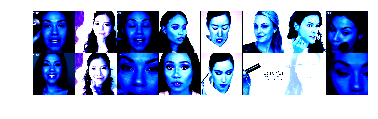

('label:', array([0, 1, 0, 0, 0, 0, 0, 0]))


In [27]:
vsiamese_testDataset  = SiameseNetworkDataset(
        path=Config.imageFiles_path['test'],
        split='test',
        gap = gap
)

vis_dataloader = DataLoader(vsiamese_testDataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print "label:",example_batch[2].numpy()

# Model Training

Neural Net Definition

In [30]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        resnet18 = torchvision.models.resnet18(pretrained = True)
        self.cnn1 = resnet18
        num_ftrs = resnet18.fc.out_features
        
        self.fc1 = nn.Sequential(
            nn.Linear(num_ftrs*2, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 2)
        )

    def forward_once(self, x):
        output = self.cnn1(x)   
        output = output.view(output.size()[0], -1)

        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        #concate output1&output2
        output = torch.cat((output1, output2), dim=1)
        output = self.fc1(output)
        
        return output

In [31]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    logging.info('Save checkpoint fo {}'.format(filename))
    
def mkdir(d):
    if not os.path.isdir(d) and not os.path.exists(d):
        os.system('mkdir -p {}'.format(d))

load data

In [32]:
train_dataloader = DataLoader(siamese_trainDataset,
                        shuffle=True,
                        num_workers=0,
                        pin_memory = True,
                        batch_size=Config.train_batch_size)
test_dataloader = DataLoader(siamese_testDataset,
                             num_workers=0,
                             shuffle=True,
                             pin_memory = True,
                             batch_size=Config.test_batch_size)

model parameters set

In [33]:
net = SiameseNetwork().cuda()
#net = SiameseNetwork()
criterion = nn.CrossEntropyLoss()
base_lr = 0.0001
step_size = 5
Config.train_number_epochs = 20
optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

In [34]:
log_file = "./contrastive_loss/"
snapshot = "./checkpoints/"
mkdir(snapshot)
mkdir(log_file)
counter = []
loss_history = [] 
iteration_number = 0
init_epoch = 0

In [35]:
lr = base_lr
lr_iter = 0
for epoch in range(init_epoch,Config.train_number_epochs):
    scheduler.step()
    lr_iter += 1
    #train for one epoch-----------------------------------------------------------------------------------
    net.train()
    epoch_loss = 0.0
    epoch_acc = 0.0
    i = 0
    with tqdm(train_dataloader, position=0, leave=True) as t:
        for data in t:
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda(), label.cuda()
            optimizer.zero_grad()
        
            output= net(img0,img1)
            loss_contrastive = criterion(output,label)
        
            epoch_loss += loss_contrastive[0].item()
            pred = torch.max(output, 1)[1]
            epoch_correct = (pred == label).sum()
            epoch_acc += epoch_correct[0].item()
        
            loss_contrastive.backward()
            optimizer.step()
            iters = len(siamese_trainDataset)/Config.train_batch_size
            if i % int(iters/10) == 0 :
                iteration_number +=iters
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
            i += 1  
        if lr_iter%step_size == 0:
            lr = lr*0.1
    t.close()    
    print('Epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}'.format(epoch, epoch_loss / (len(siamese_trainDataset)), epoch_acc / (len(siamese_trainDataset))))     
    
    #evaluate for evach epoch----------------------------------------------------------------------------------
    net.eval()
    eval_acc = 0.0
    eval_loss = 0.0
    i = 0
    with tqdm(test_dataloader, position=0, leave=True) as test:
        for data in test:
            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            out = net(img0,img1)
            loss_contrastive = criterion(out,label)
            
            pred = torch.max(out, 1)[1]
            num_correct = (pred == label).sum()
            eval_acc += num_correct[0].item()
            eval_loss += loss_contrastive[0].item()
            i += 1
    test.close()
    print('Epoch: {}, Test Loss: {:.6f}, Test Acc: {:.6f}'.format(epoch,eval_loss/len(siamese_testDataset),eval_acc/len(siamese_testDataset)))
    #write to logfile
    logfile=open(log_file + 'contrastive_gap{}.txt'.format(gap),'a')
    logfile.write( 'Epoch: {},lr: {:.6f}, Train Loss: {:.6f}, Train Acc: {:.6f}, Test Loss: {:.6f}, Test Acc: {:.6f}\n'.format(
        epoch, lr, epoch_loss / len(siamese_trainDataset), epoch_acc / len(siamese_trainDataset),
        eval_loss/len(siamese_testDataset),eval_acc/len(siamese_testDataset)))
    logfile.close()
    
    #save model paramers for each epoch
    filename = snapshot+'checkpoint_gap{}_epoch{}.pth.tar'.format(gap,epoch)
    save_checkpoint(
        {
            'epoch':epoch,
            'lr':lr,
            'gap':gap,
            'state_dict':net.state_dict()
        },
        filename
    )
#show_plot(counter,loss_history)

  0%|          | 0/231 [00:00<?, ?it/s]/data3/yll/anaconda3/envs/python27/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/data3/yll/anaconda3/envs/python27/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  0%|          | 0/54 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.020627, Train Acc: 0.609419


/data3/yll/anaconda3/envs/python27/lib/python2.7/site-packages/ipykernel_launcher.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/data3/yll/anaconda3/envs/python27/lib/python2.7/site-packages/ipykernel_launcher.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  0%|          | 0/231 [00:00<?, ?it/s]

Epoch: 0, Test Loss: 0.020092, Test Acc: 0.630510


  4%|▎         | 2/54 [00:00<00:04, 11.66it/s]

Epoch: 1, Train Loss: 0.016817, Train Acc: 0.739748


  0%|          | 0/231 [00:00<?, ?it/s]

Epoch: 1, Test Loss: 0.018712, Test Acc: 0.658353


 88%|████████▊ | 203/231 [00:25<00:03,  8.01it/s]


KeyboardInterrupt: 

# Model Evaluation


In [46]:
def Evaluation(test_dataloader,model,siamese_testDataset):
    model.eval()
    eval_acc = 0.0
    for data in tqdm(test_dataloader):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        torch.no_grad()
        out = model(img0,img1)
        pred = torch.max(out, 1)[1]
        num_correct = (pred == label).sum()
        eval_acc += num_correct[0].item()
    eval_acc =  eval_acc/len(siamese_testDataset)
    print('epoch:{}  test acc: {:.6f}'.format(epoch,eval_acc))

In [47]:
checkpoint_path = './pretrain_model/pairwise_with_CL.pth.tar' #Set your chenckpoint path here
checkpoint = torch.load(checkpoint_path)
model = SiameseNetwork().cuda()
model.load_state_dict(checkpoint['state_dict'])
epoch = checkpoint['epoch']
siamese_testDataset  = SiameseNetworkDataset(
        path=Config.imageFiles_path['test'],
        split='test',
        gap = [1,2,3,4,5]
)
print(len(siamese_testDataset))
test_dataloader = DataLoader(siamese_testDataset,num_workers=0,shuffle=True,pin_memory = True,batch_size=Config.test_batch_size)
Evaluation(test_dataloader,model,siamese_testDataset)


  0%|          | 0/54 [00:00<?, ?it/s]/data3/yll/anaconda3/envs/python27/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()

  2%|▏         | 1/54 [00:00<00:05,  9.10it/s]

1724



 61%|██████    | 33/54 [00:03<00:02,  9.83it/s]

KeyboardInterrupt: 

# Calculate choice accuracy on image ordering task 

In [48]:
'''
Set your chenckpoint path here
'''
set_checkpoint_path = './pretrain_model/pairwise_with_CL.pth.tar' 

In [54]:
def Get_Validation_Info(json_path):
    qinfos = []
    with open(json_path, "r") as file:
        for index,f in enumerate(file):
            line  = json.loads(f)
            question_info = {}
            
            question_info['question_id'] = line['question_id']# number: 1 (related image dir name: 1/)
            question_info['video_id']  = line['video_id']#"-9GYpCvGIgM"
            question_info['step_caption'] = line['step_caption']#list of step captions
            question_info['groundtruth'] = line['groundtruth'] #[4, 1, 2, 5, 3]
            question_info['candidate_answer'] = line['candidate_answer']
            qinfos.append(question_info)
    return qinfos  

def Get_QueryImages(imgs_path):
    imgs = []
    transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize(224),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
        ])
    img_name = sorted(os.listdir(imgs_path))
    for n in img_name:
        if n[-4:] != '.jpg':
            continue
        img_path = imgs_path + n
        with open(img_path, 'rb') as f:
            img = PIL.Image.open(f)
            img = img.convert('RGB') 
            img = transform(img)
            imgs.append(img)
    return imgs

def if_same(select_answer,ground_truth):
    count = 0
    for i in range(len(select_answer)):
        count += (select_answer[i] == ground_truth[i])
    return int(count == 5)

def json_data_save(path, data):
    jsdata = json.dumps(data)
    jsfile = open(path, 'w')
    jsfile.write(jsdata)
    jsfile.close() 

In [50]:
from scipy.stats import pearsonr
import json
from Levenshtein import *

img_path = {}
img_path['valid'] = "../../../YouMakeup/data/task/image_ordering/valid/images/"
img_path['test'] = "../../../YouMakeup/data/task/image_ordering/test/images/"

question_path = {}
question_path['valid'] = "../../../YouMakeup/data/task/image_ordering/valid/image_ordering_validation.json"
question_path['test'] = "../../../YouMakeup/data/task/image_ordering/test/image_ordering_test.json"

init_pic = {}
final_answer = {}
init_pic_acc = {}
choice_acc = {}
for split in  ["valid","test"]:
    images_path = img_path[split]
    questions_info = Get_Validation_Info(question_path[split])
    correct_choice_num = 0.0
    init_pic_correct_num = 0.0
    init_pic[split] = []
    select_answer = []
    final_answer[split] = {} #save predict answer
    
    #load model
    model = SiameseNetwork().cuda()
    checkpoint_path =  set_checkpoint_path 
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    for i,query in enumerate(questions_info):
        #get five query imgs
        img_dir = str(query['question_id'])
        imgs_path = images_path + img_dir + '/'
        imgs = Get_QueryImages(imgs_path)
        #1-2，1-3，1-4，1-5，2-3，2-4，2-5，3-4，3-5，4-5 pairs comparasion
        imgs_list1 = [imgs[0],imgs[0],imgs[0],imgs[0],imgs[1],imgs[1],imgs[1],imgs[2],imgs[2],imgs[3]]
        imgs_list2 = [imgs[1],imgs[2],imgs[3],imgs[4],imgs[2],imgs[3],imgs[4],imgs[3],imgs[4],imgs[4]]
        imgs_list1 = torch.stack(imgs_list1).float()
        imgs_list1 = torch.autograd.Variable(imgs_list1).cuda()
        imgs_list2 = torch.stack(imgs_list2).float()
        imgs_list2 = torch.autograd.Variable(imgs_list2).cuda()
        pred = None
        predc = None
        with torch.no_grad():
            out = F.softmax(model(imgs_list1,imgs_list2))
            pred = np.array(torch.max(out, 1)[1])
            predc = np.array(out[:,1])
 
        ground_truth = query['groundtruth']
        print "--------{}   query {} -------".format(split,i+1)
        print "ground truth:",ground_truth
        
        #choose answer algorithm
        pred_dict = {'12':predc[0],'13':predc[1],'14':predc[2],'15':predc[3],'23':predc[4],'24':predc[5],'25':predc[6],'34':predc[7],'35':predc[8],'45':predc[9],
                 '21':1-predc[0],'31':1-predc[1],'41':1-predc[2],'51':1-predc[3],'32':1-predc[4],'42':1-predc[5],'52':1-predc[6],'43':1-predc[7],'53':1-predc[8],'54':1-predc[9]}
        max_score = -1
        confidence = {}
        for answer in query['candidate_answer']:
            score = 0
            pairs = []
            for j in range(4):
                for k in range(j+1,5):   
                    pairs.append(str(answer[k])+str(answer[j]))
            for p in pairs:
                score += pred_dict[p]
            confidence[str(answer)] = score
            if score > max_score:
                max_score = score
                select_answer = answer
        count = if_same(select_answer,ground_truth)
        correct_choice_num += count
        print "choose answer:",select_answer, bool(count)
        final_answer[split][query['question_id']] = select_answer

    
        #select init image which has the highest average pairwise comparison probability
        pick_init_pic = -1
        max_prob = -1
        for img_id in ['1','2','3','4','5']:
            prob = 0.0
            for rest_id in ['1','2','3','4','5']:
                if rest_id != img_id:
                    prob += pred_dict[rest_id+img_id]
            prob /= 4.0
            if prob > max_prob:
                max_prob = prob
                pick_init_pic = int(img_id)
        init_pic_correct_num += int(ground_truth[0] == pick_init_pic)
        init_pic[split].append(pick_init_pic)
        
        #calculate choice acc and init pic selec acc
        init_pic_acc[split] = init_pic_correct_num/len(questions_info)
        choice_acc[split] = correct_choice_num/len(questions_info)

/data3/yll/anaconda3/envs/python27/lib/python2.7/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


------query 1  ground truth [4, 1, 2, 5, 3]-------
choose answer: [4, 1, 2, 5, 3] True
------query 2  ground truth [2, 1, 4, 3, 5]-------
choose answer: [2, 1, 4, 3, 5] True
------query 3  ground truth [1, 3, 2, 5, 4]-------
choose answer: [3, 5, 4, 1, 2] False
------query 4  ground truth [5, 3, 4, 1, 2]-------
choose answer: [5, 3, 4, 1, 2] True
------query 5  ground truth [1, 5, 3, 4, 2]-------
choose answer: [1, 5, 3, 4, 2] True
------query 6  ground truth [2, 1, 4, 5, 3]-------
choose answer: [2, 1, 4, 5, 3] True
------query 7  ground truth [1, 2, 4, 5, 3]-------
choose answer: [4, 2, 3, 1, 5] False
------query 8  ground truth [2, 3, 4, 1, 5]-------
choose answer: [3, 4, 1, 5, 2] False
------query 9  ground truth [2, 5, 1, 4, 3]-------
choose answer: [2, 5, 1, 4, 3] True
------query 10  ground truth [2, 4, 5, 3, 1]-------
choose answer: [2, 4, 5, 3, 1] True
------query 11  ground truth [3, 1, 2, 5, 4]-------
choose answer: [3, 1, 2, 5, 4] True
------query 12  ground truth [4, 5, 2,

------query 95  ground truth [3, 2, 4, 1, 5]-------
choose answer: [3, 2, 4, 1, 5] True
------query 96  ground truth [2, 5, 3, 4, 1]-------
choose answer: [2, 5, 3, 4, 1] True
------query 97  ground truth [2, 1, 4, 5, 3]-------
choose answer: [2, 1, 4, 5, 3] True
------query 98  ground truth [2, 1, 3, 5, 4]-------
choose answer: [2, 1, 3, 5, 4] True
------query 99  ground truth [1, 3, 5, 2, 4]-------
choose answer: [1, 3, 5, 2, 4] True
------query 100  ground truth [5, 1, 3, 4, 2]-------
choose answer: [5, 1, 3, 4, 2] True
------query 101  ground truth [2, 4, 3, 5, 1]-------
choose answer: [2, 4, 3, 5, 1] True
------query 102  ground truth [4, 3, 2, 5, 1]-------
choose answer: [2, 3, 1, 4, 5] False
------query 103  ground truth [1, 5, 4, 2, 3]-------
choose answer: [1, 5, 4, 2, 3] True
------query 104  ground truth [5, 4, 2, 1, 3]-------
choose answer: [4, 2, 1, 3, 5] False
------query 105  ground truth [1, 3, 4, 2, 5]-------
choose answer: [4, 5, 3, 1, 2] False
------query 106  ground

------query 187  ground truth [5, 1, 2, 4, 3]-------
choose answer: [5, 1, 2, 4, 3] True
------query 188  ground truth [2, 5, 3, 1, 4]-------
choose answer: [2, 5, 3, 1, 4] True
------query 189  ground truth [1, 5, 4, 3, 2]-------
choose answer: [5, 1, 4, 3, 2] False
------query 190  ground truth [2, 4, 5, 3, 1]-------
choose answer: [2, 4, 5, 3, 1] True
------query 191  ground truth [5, 4, 3, 2, 1]-------
choose answer: [5, 4, 3, 2, 1] True
------query 192  ground truth [2, 1, 3, 5, 4]-------
choose answer: [2, 1, 3, 5, 4] True
------query 193  ground truth [4, 3, 2, 1, 5]-------
choose answer: [4, 3, 2, 1, 5] True
------query 194  ground truth [5, 2, 3, 4, 1]-------
choose answer: [5, 2, 3, 4, 1] True
------query 195  ground truth [1, 3, 2, 4, 5]-------
choose answer: [1, 3, 2, 4, 5] True
------query 196  ground truth [4, 2, 1, 3, 5]-------
choose answer: [2, 4, 3, 1, 5] False
------query 197  ground truth [1, 2, 3, 5, 4]-------
choose answer: [1, 3, 2, 4, 5] False
------query 198  g

------query 280  ground truth [5, 4, 1, 2, 3]-------
choose answer: [5, 4, 1, 2, 3] True
------query 281  ground truth [3, 5, 1, 4, 2]-------
choose answer: [3, 5, 1, 4, 2] True
------query 282  ground truth [2, 1, 5, 4, 3]-------
choose answer: [2, 1, 5, 4, 3] True
------query 283  ground truth [2, 1, 4, 3, 5]-------
choose answer: [2, 1, 4, 3, 5] True
------query 284  ground truth [3, 5, 1, 2, 4]-------
choose answer: [3, 5, 1, 2, 4] True
------query 285  ground truth [1, 4, 3, 2, 5]-------
choose answer: [1, 4, 3, 2, 5] True
------query 286  ground truth [4, 5, 2, 3, 1]-------
choose answer: [4, 5, 2, 3, 1] True
------query 287  ground truth [5, 2, 3, 1, 4]-------
choose answer: [5, 2, 3, 1, 4] True
------query 288  ground truth [4, 1, 2, 5, 3]-------
choose answer: [4, 3, 1, 2, 5] False
------query 289  ground truth [2, 4, 3, 5, 1]-------
choose answer: [2, 4, 3, 5, 1] True
------query 290  ground truth [2, 4, 3, 1, 5]-------
choose answer: [2, 4, 3, 1, 5] True
------query 291  gro

------query 372  ground truth [2, 3, 4, 1, 5]-------
choose answer: [2, 3, 4, 1, 5] True
------query 373  ground truth [5, 1, 2, 3, 4]-------
choose answer: [1, 4, 3, 2, 5] False
------query 374  ground truth [5, 3, 2, 4, 1]-------
choose answer: [5, 3, 2, 4, 1] True
------query 375  ground truth [5, 2, 3, 4, 1]-------
choose answer: [5, 2, 3, 4, 1] True
------query 376  ground truth [1, 3, 5, 4, 2]-------
choose answer: [1, 3, 4, 2, 5] False
------query 377  ground truth [5, 3, 1, 2, 4]-------
choose answer: [5, 3, 1, 2, 4] True
------query 378  ground truth [2, 4, 3, 1, 5]-------
choose answer: [3, 2, 4, 1, 5] False
------query 379  ground truth [3, 1, 4, 5, 2]-------
choose answer: [3, 1, 4, 5, 2] True
------query 380  ground truth [1, 3, 5, 2, 4]-------
choose answer: [1, 3, 5, 2, 4] True
------query 381  ground truth [4, 5, 3, 1, 2]-------
choose answer: [1, 3, 5, 2, 4] False
------query 382  ground truth [1, 2, 4, 5, 3]-------
choose answer: [1, 2, 4, 5, 3] True
------query 383  

------query 464  ground truth [3, 4, 5, 2, 1]-------
choose answer: [3, 4, 5, 2, 1] True
------query 465  ground truth [5, 2, 4, 1, 3]-------
choose answer: [5, 2, 4, 1, 3] True
------query 466  ground truth [4, 1, 3, 5, 2]-------
choose answer: [1, 4, 3, 5, 2] False
------query 467  ground truth [2, 1, 3, 5, 4]-------
choose answer: [2, 1, 3, 5, 4] True
------query 468  ground truth [2, 3, 1, 5, 4]-------
choose answer: [2, 3, 1, 5, 4] True
------query 469  ground truth [3, 2, 1, 4, 5]-------
choose answer: [3, 2, 1, 4, 5] True
------query 470  ground truth [2, 1, 5, 4, 3]-------
choose answer: [2, 1, 5, 4, 3] True
------query 471  ground truth [4, 2, 1, 5, 3]-------
choose answer: [5, 4, 3, 1, 2] False
------query 472  ground truth [3, 2, 4, 1, 5]-------
choose answer: [2, 1, 5, 4, 3] False
------query 473  ground truth [3, 2, 5, 4, 1]-------
choose answer: [2, 1, 3, 5, 4] False
------query 474  ground truth [1, 2, 3, 5, 4]-------
choose answer: [5, 2, 3, 1, 4] False
------query 475 

------query 556  ground truth [1, 2, 5, 4, 3]-------
choose answer: [1, 2, 5, 4, 3] True
------query 557  ground truth [2, 5, 1, 3, 4]-------
choose answer: [2, 5, 1, 3, 4] True
------query 558  ground truth [3, 1, 4, 2, 5]-------
choose answer: [3, 1, 4, 2, 5] True
------query 559  ground truth [1, 2, 5, 3, 4]-------
choose answer: [1, 2, 5, 3, 4] True
------query 560  ground truth [3, 1, 4, 5, 2]-------
choose answer: [3, 1, 4, 5, 2] True
------query 561  ground truth [5, 2, 4, 3, 1]-------
choose answer: [5, 2, 4, 3, 1] True
------query 562  ground truth [2, 4, 3, 5, 1]-------
choose answer: [2, 4, 3, 5, 1] True
------query 563  ground truth [2, 5, 1, 4, 3]-------
choose answer: [2, 5, 1, 4, 3] True
------query 564  ground truth [5, 2, 4, 1, 3]-------
choose answer: [5, 2, 4, 1, 3] True
------query 565  ground truth [2, 5, 1, 4, 3]-------
choose answer: [2, 5, 1, 4, 3] True
------query 566  ground truth [1, 3, 4, 2, 5]-------
choose answer: [1, 3, 4, 2, 5] True
------query 567  grou

------query 648  ground truth [1, 3, 2, 5, 4]-------
choose answer: [1, 3, 2, 5, 4] True
------query 649  ground truth [5, 4, 2, 1, 3]-------
choose answer: [5, 4, 2, 1, 3] True
------query 650  ground truth [2, 4, 1, 5, 3]-------
choose answer: [2, 4, 1, 5, 3] True
------query 651  ground truth [3, 2, 5, 1, 4]-------
choose answer: [3, 2, 5, 1, 4] True
------query 652  ground truth [4, 1, 2, 3, 5]-------
choose answer: [4, 1, 2, 3, 5] True
------query 653  ground truth [2, 4, 3, 1, 5]-------
choose answer: [2, 4, 3, 1, 5] True
------query 654  ground truth [1, 5, 2, 3, 4]-------
choose answer: [1, 5, 2, 3, 4] True
------query 655  ground truth [1, 4, 2, 3, 5]-------
choose answer: [1, 2, 3, 5, 4] False
------query 656  ground truth [5, 2, 1, 4, 3]-------
choose answer: [5, 2, 1, 4, 3] True
------query 657  ground truth [4, 3, 5, 2, 1]-------
choose answer: [4, 3, 5, 2, 1] True
------query 658  ground truth [1, 2, 4, 5, 3]-------
choose answer: [1, 2, 4, 5, 3] True
------query 659  gro

------query 741  ground truth [3, 2, 5, 4, 1]-------
choose answer: [2, 3, 1, 5, 4] False
------query 742  ground truth [5, 1, 3, 4, 2]-------
choose answer: [1, 3, 2, 5, 4] False
------query 743  ground truth [4, 5, 1, 3, 2]-------
choose answer: [4, 5, 1, 3, 2] True
------query 744  ground truth [3, 2, 5, 1, 4]-------
choose answer: [3, 2, 5, 1, 4] True
------query 745  ground truth [4, 5, 1, 2, 3]-------
choose answer: [5, 4, 1, 3, 2] False
------query 746  ground truth [2, 1, 3, 4, 5]-------
choose answer: [2, 1, 3, 4, 5] True
------query 747  ground truth [3, 2, 4, 1, 5]-------
choose answer: [2, 4, 1, 3, 5] False
------query 748  ground truth [3, 4, 5, 1, 2]-------
choose answer: [3, 4, 5, 1, 2] True
------query 749  ground truth [1, 2, 3, 4, 5]-------
choose answer: [1, 2, 3, 4, 5] True
------query 750  ground truth [2, 5, 1, 3, 4]-------
choose answer: [2, 5, 1, 3, 4] True
------query 751  ground truth [3, 2, 4, 1, 5]-------
choose answer: [2, 3, 5, 4, 1] False
------query 752 

------query 833  ground truth [4, 3, 5, 2, 1]-------
choose answer: [5, 3, 2, 1, 4] False
------query 834  ground truth [1, 3, 2, 4, 5]-------
choose answer: [1, 3, 2, 4, 5] True
------query 835  ground truth [4, 2, 3, 1, 5]-------
choose answer: [4, 2, 3, 1, 5] True
------query 836  ground truth [4, 2, 1, 3, 5]-------
choose answer: [4, 2, 1, 3, 5] True
------query 837  ground truth [4, 5, 2, 3, 1]-------
choose answer: [4, 5, 2, 3, 1] True
------query 838  ground truth [4, 5, 1, 2, 3]-------
choose answer: [5, 2, 1, 3, 4] False
------query 839  ground truth [5, 2, 3, 1, 4]-------
choose answer: [5, 2, 3, 1, 4] True
------query 840  ground truth [4, 2, 3, 1, 5]-------
choose answer: [4, 2, 3, 1, 5] True
------query 841  ground truth [3, 1, 2, 4, 5]-------
choose answer: [3, 1, 5, 4, 2] False
------query 842  ground truth [1, 3, 5, 2, 4]-------
choose answer: [5, 2, 4, 3, 1] False
------query 843  ground truth [4, 5, 3, 1, 2]-------
choose answer: [4, 5, 3, 1, 2] True
------query 844  

------query 925  ground truth [3, 5, 2, 4, 1]-------
choose answer: [5, 2, 3, 1, 4] False
------query 926  ground truth [2, 5, 4, 1, 3]-------
choose answer: [2, 5, 4, 1, 3] True
------query 927  ground truth [5, 4, 2, 3, 1]-------
choose answer: [5, 2, 4, 3, 1] False
------query 928  ground truth [1, 3, 4, 2, 5]-------
choose answer: [1, 3, 4, 2, 5] True
------query 929  ground truth [1, 4, 2, 3, 5]-------
choose answer: [4, 5, 2, 1, 3] False
------query 930  ground truth [4, 3, 5, 2, 1]-------
choose answer: [4, 3, 5, 2, 1] True
------query 931  ground truth [4, 3, 5, 2, 1]-------
choose answer: [4, 3, 5, 2, 1] True
------query 932  ground truth [1, 5, 2, 4, 3]-------
choose answer: [1, 5, 2, 3, 4] False
------query 933  ground truth [1, 3, 5, 4, 2]-------
choose answer: [1, 3, 5, 4, 2] True
------query 934  ground truth [3, 2, 1, 4, 5]-------
choose answer: [3, 2, 1, 4, 5] True
------query 935  ground truth [5, 4, 2, 1, 3]-------
choose answer: [5, 4, 2, 1, 3] True
------query 936  

------query 1017  ground truth [2, 4, 3, 5, 1]-------
choose answer: [5, 2, 1, 3, 4] False
------query 1018  ground truth [3, 5, 2, 4, 1]-------
choose answer: [1, 5, 3, 2, 4] False
------query 1019  ground truth [3, 5, 4, 2, 1]-------
choose answer: [2, 4, 5, 3, 1] False
------query 1020  ground truth [1, 2, 4, 5, 3]-------
choose answer: [5, 1, 4, 2, 3] False
------query 1021  ground truth [3, 1, 2, 4, 5]-------
choose answer: [3, 1, 2, 4, 5] True
------query 1022  ground truth [1, 5, 3, 4, 2]-------
choose answer: [1, 5, 3, 4, 2] True
------query 1023  ground truth [4, 2, 3, 5, 1]-------
choose answer: [4, 2, 3, 5, 1] True
------query 1024  ground truth [5, 4, 1, 3, 2]-------
choose answer: [5, 4, 1, 3, 2] True
------query 1025  ground truth [4, 5, 2, 3, 1]-------
choose answer: [4, 5, 2, 3, 1] True
------query 1026  ground truth [5, 1, 3, 2, 4]-------
choose answer: [5, 1, 3, 2, 4] True
------query 1027  ground truth [3, 5, 2, 1, 4]-------
choose answer: [3, 5, 2, 1, 4] True
------

------query 1109  ground truth [2, 5, 1, 3, 4]-------
choose answer: [2, 5, 1, 3, 4] True
------query 1110  ground truth [1, 2, 4, 5, 3]-------
choose answer: [4, 2, 5, 1, 3] False
------query 1111  ground truth [5, 1, 2, 3, 4]-------
choose answer: [2, 5, 3, 1, 4] False
------query 1112  ground truth [4, 3, 1, 2, 5]-------
choose answer: [2, 3, 5, 1, 4] False
------query 1113  ground truth [4, 5, 1, 3, 2]-------
choose answer: [5, 3, 4, 1, 2] False
------query 1114  ground truth [3, 4, 5, 1, 2]-------
choose answer: [3, 4, 5, 1, 2] True
------query 1115  ground truth [5, 2, 3, 1, 4]-------
choose answer: [1, 5, 2, 3, 4] False
------query 1116  ground truth [2, 4, 5, 3, 1]-------
choose answer: [2, 4, 5, 3, 1] True
------query 1117  ground truth [1, 5, 3, 4, 2]-------
choose answer: [2, 3, 5, 4, 1] False
------query 1118  ground truth [1, 5, 3, 4, 2]-------
choose answer: [1, 5, 3, 4, 2] True
------query 1119  ground truth [3, 5, 2, 4, 1]-------
choose answer: [5, 1, 2, 4, 3] False
---

------query 1200  ground truth [4, 3, 2, 5, 1]-------
choose answer: [4, 3, 2, 5, 1] True
------query 1  ground truth [4, 3, 1, 2, 5]-------
choose answer: [4, 3, 1, 2, 5] True
------query 2  ground truth [5, 3, 2, 4, 1]-------
choose answer: [4, 5, 2, 3, 1] False
------query 3  ground truth [3, 4, 1, 5, 2]-------
choose answer: [2, 4, 5, 1, 3] False
------query 4  ground truth [3, 4, 5, 1, 2]-------
choose answer: [3, 4, 5, 1, 2] True
------query 5  ground truth [1, 2, 4, 3, 5]-------
choose answer: [1, 2, 4, 3, 5] True
------query 6  ground truth [3, 2, 4, 5, 1]-------
choose answer: [4, 1, 5, 2, 3] False
------query 7  ground truth [4, 3, 5, 1, 2]-------
choose answer: [4, 3, 5, 1, 2] True
------query 8  ground truth [5, 4, 2, 1, 3]-------
choose answer: [2, 4, 5, 1, 3] False
------query 9  ground truth [2, 5, 4, 1, 3]-------
choose answer: [2, 5, 4, 1, 3] True
------query 10  ground truth [1, 4, 2, 3, 5]-------
choose answer: [1, 4, 2, 3, 5] True
------query 11  ground truth [4, 2,

------query 93  ground truth [1, 2, 4, 5, 3]-------
choose answer: [1, 2, 4, 5, 3] True
------query 94  ground truth [1, 5, 4, 3, 2]-------
choose answer: [1, 5, 4, 3, 2] True
------query 95  ground truth [5, 2, 3, 1, 4]-------
choose answer: [5, 2, 3, 1, 4] True
------query 96  ground truth [3, 1, 5, 2, 4]-------
choose answer: [3, 1, 2, 4, 5] False
------query 97  ground truth [1, 2, 3, 5, 4]-------
choose answer: [1, 2, 3, 5, 4] True
------query 98  ground truth [4, 1, 2, 3, 5]-------
choose answer: [4, 1, 2, 3, 5] True
------query 99  ground truth [5, 3, 1, 2, 4]-------
choose answer: [5, 3, 1, 2, 4] True
------query 100  ground truth [3, 4, 5, 1, 2]-------
choose answer: [3, 4, 5, 1, 2] True
------query 101  ground truth [2, 5, 3, 4, 1]-------
choose answer: [2, 3, 5, 1, 4] False
------query 102  ground truth [5, 3, 1, 4, 2]-------
choose answer: [5, 3, 1, 4, 2] True
------query 103  ground truth [5, 3, 4, 1, 2]-------
choose answer: [5, 3, 4, 1, 2] True
------query 104  ground tr

------query 186  ground truth [5, 2, 1, 3, 4]-------
choose answer: [5, 2, 1, 3, 4] True
------query 187  ground truth [1, 5, 4, 2, 3]-------
choose answer: [1, 5, 4, 2, 3] True
------query 188  ground truth [2, 1, 4, 3, 5]-------
choose answer: [1, 2, 4, 3, 5] False
------query 189  ground truth [4, 1, 3, 5, 2]-------
choose answer: [3, 4, 2, 5, 1] False
------query 190  ground truth [5, 4, 1, 3, 2]-------
choose answer: [5, 4, 3, 2, 1] False
------query 191  ground truth [1, 3, 4, 5, 2]-------
choose answer: [1, 3, 4, 5, 2] True
------query 192  ground truth [2, 5, 1, 3, 4]-------
choose answer: [4, 2, 5, 1, 3] False
------query 193  ground truth [2, 4, 1, 3, 5]-------
choose answer: [2, 4, 1, 3, 5] True
------query 194  ground truth [4, 1, 2, 3, 5]-------
choose answer: [4, 1, 2, 3, 5] True
------query 195  ground truth [3, 4, 5, 2, 1]-------
choose answer: [3, 4, 5, 2, 1] True
------query 196  ground truth [3, 5, 1, 2, 4]-------
choose answer: [3, 5, 1, 2, 4] True
------query 197  

------query 278  ground truth [2, 3, 5, 4, 1]-------
choose answer: [2, 3, 5, 4, 1] True
------query 279  ground truth [1, 2, 3, 4, 5]-------
choose answer: [1, 2, 3, 4, 5] True
------query 280  ground truth [3, 4, 2, 1, 5]-------
choose answer: [3, 4, 2, 1, 5] True
------query 281  ground truth [3, 2, 1, 5, 4]-------
choose answer: [3, 2, 1, 5, 4] True
------query 282  ground truth [4, 2, 5, 3, 1]-------
choose answer: [4, 2, 5, 3, 1] True
------query 283  ground truth [1, 3, 2, 5, 4]-------
choose answer: [1, 3, 2, 5, 4] True
------query 284  ground truth [3, 1, 4, 2, 5]-------
choose answer: [3, 1, 4, 2, 5] True
------query 285  ground truth [2, 1, 4, 5, 3]-------
choose answer: [2, 1, 4, 5, 3] True
------query 286  ground truth [5, 1, 4, 2, 3]-------
choose answer: [5, 1, 4, 2, 3] True
------query 287  ground truth [2, 5, 1, 3, 4]-------
choose answer: [2, 5, 1, 3, 4] True
------query 288  ground truth [4, 3, 5, 2, 1]-------
choose answer: [4, 3, 5, 2, 1] True
------query 289  grou

------query 370  ground truth [1, 2, 4, 5, 3]-------
choose answer: [1, 2, 4, 5, 3] True
------query 371  ground truth [2, 5, 4, 1, 3]-------
choose answer: [2, 5, 4, 1, 3] True
------query 372  ground truth [5, 3, 4, 1, 2]-------
choose answer: [5, 3, 4, 1, 2] True
------query 373  ground truth [2, 3, 4, 5, 1]-------
choose answer: [2, 5, 4, 3, 1] False
------query 374  ground truth [1, 5, 2, 4, 3]-------
choose answer: [1, 5, 2, 4, 3] True
------query 375  ground truth [3, 5, 2, 1, 4]-------
choose answer: [3, 5, 2, 1, 4] True
------query 376  ground truth [4, 5, 3, 2, 1]-------
choose answer: [4, 5, 3, 2, 1] True
------query 377  ground truth [2, 5, 3, 4, 1]-------
choose answer: [2, 5, 3, 4, 1] True
------query 378  ground truth [5, 4, 1, 2, 3]-------
choose answer: [5, 4, 1, 2, 3] True
------query 379  ground truth [4, 1, 3, 2, 5]-------
choose answer: [4, 1, 3, 2, 5] True
------query 380  ground truth [5, 4, 3, 2, 1]-------
choose answer: [5, 4, 3, 2, 1] True
------query 381  gro

------query 462  ground truth [2, 4, 1, 3, 5]-------
choose answer: [2, 4, 1, 3, 5] True
------query 463  ground truth [5, 1, 2, 3, 4]-------
choose answer: [5, 2, 3, 4, 1] False
------query 464  ground truth [4, 5, 1, 3, 2]-------
choose answer: [4, 5, 1, 3, 2] True
------query 465  ground truth [4, 2, 3, 5, 1]-------
choose answer: [2, 5, 3, 1, 4] False
------query 466  ground truth [3, 1, 2, 4, 5]-------
choose answer: [4, 2, 3, 1, 5] False
------query 467  ground truth [3, 4, 1, 5, 2]-------
choose answer: [3, 5, 1, 4, 2] False
------query 468  ground truth [1, 4, 2, 3, 5]-------
choose answer: [3, 4, 1, 2, 5] False
------query 469  ground truth [4, 5, 3, 2, 1]-------
choose answer: [2, 4, 3, 5, 1] False
------query 470  ground truth [2, 5, 4, 3, 1]-------
choose answer: [4, 3, 5, 2, 1] False
------query 471  ground truth [5, 4, 3, 2, 1]-------
choose answer: [2, 1, 4, 3, 5] False
------query 472  ground truth [3, 2, 4, 5, 1]-------
choose answer: [5, 3, 4, 2, 1] False
------query 

------query 554  ground truth [5, 2, 1, 3, 4]-------
choose answer: [5, 2, 1, 3, 4] True
------query 555  ground truth [4, 5, 3, 2, 1]-------
choose answer: [4, 5, 3, 2, 1] True
------query 556  ground truth [3, 5, 4, 2, 1]-------
choose answer: [3, 5, 4, 2, 1] True
------query 557  ground truth [2, 5, 4, 3, 1]-------
choose answer: [2, 5, 4, 3, 1] True
------query 558  ground truth [5, 2, 4, 3, 1]-------
choose answer: [5, 2, 4, 3, 1] True
------query 559  ground truth [4, 2, 1, 3, 5]-------
choose answer: [4, 2, 1, 3, 5] True
------query 560  ground truth [2, 5, 4, 3, 1]-------
choose answer: [2, 5, 4, 3, 1] True
------query 561  ground truth [4, 5, 1, 3, 2]-------
choose answer: [4, 5, 1, 3, 2] True
------query 562  ground truth [5, 2, 4, 1, 3]-------
choose answer: [5, 2, 4, 1, 3] True
------query 563  ground truth [5, 1, 3, 2, 4]-------
choose answer: [5, 1, 3, 2, 4] True
------query 564  ground truth [1, 3, 5, 4, 2]-------
choose answer: [5, 3, 1, 4, 2] False
------query 565  gro

------query 646  ground truth [4, 1, 3, 5, 2]-------
choose answer: [4, 1, 3, 5, 2] True
------query 647  ground truth [4, 2, 5, 3, 1]-------
choose answer: [4, 2, 5, 3, 1] True
------query 648  ground truth [1, 4, 3, 2, 5]-------
choose answer: [1, 4, 3, 2, 5] True
------query 649  ground truth [3, 5, 2, 1, 4]-------
choose answer: [3, 5, 2, 1, 4] True
------query 650  ground truth [2, 5, 1, 3, 4]-------
choose answer: [2, 5, 1, 3, 4] True
------query 651  ground truth [1, 2, 3, 4, 5]-------
choose answer: [1, 3, 2, 4, 5] False
------query 652  ground truth [1, 3, 2, 5, 4]-------
choose answer: [1, 3, 2, 5, 4] True
------query 653  ground truth [2, 4, 5, 1, 3]-------
choose answer: [2, 4, 5, 1, 3] True
------query 654  ground truth [4, 5, 1, 3, 2]-------
choose answer: [4, 5, 1, 3, 2] True
------query 655  ground truth [3, 5, 1, 4, 2]-------
choose answer: [4, 1, 5, 2, 3] False
------query 656  ground truth [5, 3, 4, 1, 2]-------
choose answer: [5, 3, 4, 1, 2] True
------query 657  gr

------query 738  ground truth [5, 3, 2, 4, 1]-------
choose answer: [5, 3, 2, 4, 1] True
------query 739  ground truth [4, 5, 3, 2, 1]-------
choose answer: [4, 5, 3, 2, 1] True
------query 740  ground truth [1, 3, 2, 4, 5]-------
choose answer: [1, 3, 2, 4, 5] True
------query 741  ground truth [1, 2, 4, 5, 3]-------
choose answer: [1, 2, 4, 5, 3] True
------query 742  ground truth [4, 2, 5, 3, 1]-------
choose answer: [4, 5, 1, 3, 2] False
------query 743  ground truth [4, 5, 3, 2, 1]-------
choose answer: [5, 1, 2, 4, 3] False
------query 744  ground truth [2, 3, 1, 4, 5]-------
choose answer: [2, 3, 5, 1, 4] False
------query 745  ground truth [2, 1, 5, 3, 4]-------
choose answer: [2, 1, 5, 3, 4] True
------query 746  ground truth [5, 2, 1, 4, 3]-------
choose answer: [2, 5, 1, 4, 3] False
------query 747  ground truth [2, 1, 5, 3, 4]-------
choose answer: [1, 5, 3, 2, 4] False
------query 748  ground truth [2, 5, 1, 4, 3]-------
choose answer: [2, 5, 1, 4, 3] True
------query 749 

------query 830  ground truth [2, 5, 3, 1, 4]-------
choose answer: [2, 5, 3, 1, 4] True
------query 831  ground truth [3, 4, 5, 2, 1]-------
choose answer: [1, 5, 3, 4, 2] False
------query 832  ground truth [2, 5, 1, 4, 3]-------
choose answer: [2, 5, 1, 4, 3] True
------query 833  ground truth [4, 3, 1, 2, 5]-------
choose answer: [4, 3, 1, 2, 5] True
------query 834  ground truth [2, 5, 4, 3, 1]-------
choose answer: [2, 5, 4, 3, 1] True
------query 835  ground truth [3, 4, 5, 1, 2]-------
choose answer: [1, 2, 4, 5, 3] False
------query 836  ground truth [2, 1, 5, 3, 4]-------
choose answer: [2, 1, 5, 3, 4] True
------query 837  ground truth [5, 3, 1, 4, 2]-------
choose answer: [5, 3, 1, 4, 2] True
------query 838  ground truth [4, 2, 5, 1, 3]-------
choose answer: [4, 2, 5, 1, 3] True
------query 839  ground truth [5, 2, 4, 1, 3]-------
choose answer: [5, 2, 4, 1, 3] True
------query 840  ground truth [1, 5, 2, 4, 3]-------
choose answer: [1, 5, 2, 4, 3] True
------query 841  gr

------query 922  ground truth [5, 3, 4, 1, 2]-------
choose answer: [3, 2, 4, 5, 1] False
------query 923  ground truth [4, 1, 2, 5, 3]-------
choose answer: [4, 1, 2, 5, 3] True
------query 924  ground truth [1, 2, 5, 4, 3]-------
choose answer: [1, 2, 5, 3, 4] False
------query 925  ground truth [1, 4, 5, 2, 3]-------
choose answer: [1, 4, 5, 2, 3] True
------query 926  ground truth [4, 5, 2, 1, 3]-------
choose answer: [4, 5, 2, 1, 3] True
------query 927  ground truth [2, 5, 1, 3, 4]-------
choose answer: [2, 5, 1, 3, 4] True
------query 928  ground truth [2, 5, 3, 4, 1]-------
choose answer: [2, 5, 3, 4, 1] True
------query 929  ground truth [2, 5, 3, 1, 4]-------
choose answer: [1, 5, 2, 3, 4] False
------query 930  ground truth [5, 2, 3, 1, 4]-------
choose answer: [5, 2, 3, 1, 4] True
------query 931  ground truth [4, 3, 2, 1, 5]-------
choose answer: [4, 3, 2, 1, 5] True
------query 932  ground truth [3, 1, 5, 4, 2]-------
choose answer: [3, 1, 5, 4, 2] True
------query 933  g

------query 1014  ground truth [1, 2, 5, 4, 3]-------
choose answer: [1, 2, 5, 4, 3] True
------query 1015  ground truth [4, 5, 2, 1, 3]-------
choose answer: [4, 5, 2, 1, 3] True
------query 1016  ground truth [5, 4, 3, 1, 2]-------
choose answer: [5, 4, 3, 1, 2] True
------query 1017  ground truth [5, 3, 4, 1, 2]-------
choose answer: [4, 3, 2, 1, 5] False
------query 1018  ground truth [2, 1, 4, 5, 3]-------
choose answer: [2, 1, 4, 5, 3] True
------query 1019  ground truth [1, 2, 3, 5, 4]-------
choose answer: [1, 2, 3, 5, 4] True
------query 1020  ground truth [4, 3, 1, 2, 5]-------
choose answer: [4, 3, 1, 2, 5] True
------query 1021  ground truth [2, 5, 3, 4, 1]-------
choose answer: [3, 5, 4, 2, 1] False
------query 1022  ground truth [1, 4, 5, 2, 3]-------
choose answer: [4, 3, 2, 1, 5] False
------query 1023  ground truth [4, 5, 1, 2, 3]-------
choose answer: [4, 5, 1, 2, 3] True
------query 1024  ground truth [4, 2, 1, 5, 3]-------
choose answer: [4, 2, 1, 5, 3] True
------q

------query 1106  ground truth [4, 5, 2, 1, 3]-------
choose answer: [3, 2, 1, 5, 4] False
------query 1107  ground truth [1, 4, 2, 3, 5]-------
choose answer: [1, 4, 2, 3, 5] True
------query 1108  ground truth [3, 5, 2, 4, 1]-------
choose answer: [3, 5, 2, 4, 1] True
------query 1109  ground truth [1, 2, 5, 4, 3]-------
choose answer: [1, 2, 5, 4, 3] True
------query 1110  ground truth [4, 2, 5, 3, 1]-------
choose answer: [4, 2, 5, 3, 1] True
------query 1111  ground truth [4, 2, 1, 3, 5]-------
choose answer: [4, 2, 1, 3, 5] True
------query 1112  ground truth [4, 1, 2, 5, 3]-------
choose answer: [4, 1, 2, 5, 3] True
------query 1113  ground truth [5, 4, 1, 2, 3]-------
choose answer: [5, 4, 1, 2, 3] True
------query 1114  ground truth [5, 3, 4, 1, 2]-------
choose answer: [5, 3, 4, 1, 2] True
------query 1115  ground truth [5, 3, 4, 2, 1]-------
choose answer: [2, 5, 3, 4, 1] False
------query 1116  ground truth [2, 3, 1, 5, 4]-------
choose answer: [2, 3, 1, 5, 4] True
------qu

------query 1197  ground truth [4, 2, 5, 3, 1]-------
choose answer: [4, 2, 5, 3, 1] True
------query 1198  ground truth [5, 1, 3, 2, 4]-------
choose answer: [5, 1, 3, 2, 4] True
------query 1199  ground truth [3, 5, 4, 1, 2]-------
choose answer: [3, 5, 4, 1, 2] True
------query 1200  ground truth [3, 1, 2, 5, 4]-------
choose answer: [3, 1, 2, 5, 4] True
------query 1201  ground truth [5, 2, 3, 4, 1]-------
choose answer: [2, 4, 3, 5, 1] False
------query 1202  ground truth [2, 4, 1, 5, 3]-------
choose answer: [1, 4, 3, 5, 2] False
------query 1203  ground truth [2, 4, 5, 3, 1]-------
choose answer: [4, 1, 2, 5, 3] False
------query 1204  ground truth [3, 5, 1, 2, 4]-------
choose answer: [3, 5, 1, 2, 4] True
------query 1205  ground truth [1, 3, 2, 4, 5]-------
choose answer: [1, 3, 2, 4, 5] True
------query 1206  ground truth [1, 5, 2, 3, 4]-------
choose answer: [1, 5, 2, 3, 4] True
------query 1207  ground truth [3, 4, 2, 5, 1]-------
choose answer: [3, 4, 5, 1, 2] False
------

------query 1288  ground truth [5, 1, 2, 4, 3]-------
choose answer: [5, 1, 2, 4, 3] True
------query 1289  ground truth [4, 1, 2, 3, 5]-------
choose answer: [4, 1, 2, 3, 5] True
------query 1290  ground truth [2, 4, 1, 3, 5]-------
choose answer: [2, 4, 1, 3, 5] True
------query 1291  ground truth [3, 5, 2, 1, 4]-------
choose answer: [3, 5, 2, 1, 4] True
------query 1292  ground truth [4, 2, 1, 5, 3]-------
choose answer: [4, 2, 1, 5, 3] True
------query 1293  ground truth [5, 2, 3, 1, 4]-------
choose answer: [5, 2, 3, 1, 4] True
------query 1294  ground truth [4, 2, 1, 3, 5]-------
choose answer: [2, 3, 5, 4, 1] False
------query 1295  ground truth [4, 2, 3, 5, 1]-------
choose answer: [2, 4, 3, 5, 1] False
------query 1296  ground truth [1, 5, 3, 4, 2]-------
choose answer: [1, 5, 3, 4, 2] True
------query 1297  ground truth [4, 1, 5, 3, 2]-------
choose answer: [5, 1, 4, 2, 3] False
------query 1298  ground truth [2, 1, 3, 5, 4]-------
choose answer: [2, 1, 3, 5, 4] True
------q

------query 1380  ground truth [5, 3, 2, 1, 4]-------
choose answer: [5, 3, 2, 1, 4] True
------query 1381  ground truth [1, 2, 4, 5, 3]-------
choose answer: [1, 2, 4, 5, 3] True
------query 1382  ground truth [2, 1, 3, 5, 4]-------
choose answer: [2, 1, 5, 4, 3] False
------query 1383  ground truth [3, 1, 5, 4, 2]-------
choose answer: [3, 1, 5, 4, 2] True
------query 1384  ground truth [1, 3, 4, 2, 5]-------
choose answer: [3, 2, 1, 4, 5] False
------query 1385  ground truth [1, 3, 5, 4, 2]-------
choose answer: [4, 3, 2, 1, 5] False
------query 1386  ground truth [2, 5, 3, 4, 1]-------
choose answer: [2, 4, 5, 3, 1] False
------query 1387  ground truth [3, 4, 1, 2, 5]-------
choose answer: [2, 3, 4, 1, 5] False
------query 1388  ground truth [5, 1, 3, 4, 2]-------
choose answer: [4, 3, 2, 5, 1] False
------query 1389  ground truth [2, 4, 3, 5, 1]-------
choose answer: [2, 4, 3, 5, 1] True
------query 1390  ground truth [1, 2, 5, 4, 3]-------
choose answer: [1, 4, 5, 2, 3] False
---

------query 1471  ground truth [5, 3, 1, 4, 2]-------
choose answer: [5, 3, 1, 4, 2] True
------query 1472  ground truth [5, 4, 2, 3, 1]-------
choose answer: [5, 4, 2, 3, 1] True
------query 1473  ground truth [3, 5, 4, 2, 1]-------
choose answer: [3, 5, 4, 2, 1] True
------query 1474  ground truth [1, 3, 2, 5, 4]-------
choose answer: [1, 3, 2, 5, 4] True
------query 1475  ground truth [3, 5, 2, 1, 4]-------
choose answer: [3, 4, 5, 1, 2] False
------query 1476  ground truth [3, 5, 1, 4, 2]-------
choose answer: [3, 1, 2, 5, 4] False
------query 1477  ground truth [5, 1, 2, 3, 4]-------
choose answer: [5, 1, 2, 3, 4] True
------query 1478  ground truth [3, 4, 2, 1, 5]-------
choose answer: [3, 4, 2, 1, 5] True
------query 1479  ground truth [1, 3, 2, 5, 4]-------
choose answer: [1, 3, 2, 5, 4] True
------query 1480  ground truth [4, 2, 1, 3, 5]-------
choose answer: [4, 3, 1, 2, 5] False
------query 1481  ground truth [3, 1, 2, 4, 5]-------
choose answer: [3, 5, 2, 1, 4] False
------

In [59]:
for split in ["valid","test"]:
    print "----------------------{}-----------------------".format(split)
    np.save("init_pics_{}_{:.3f}.npy".format(split,init_pic_acc[split]),init_pic[split])
    #save predicted answers to .json
    path = "pairwise_{}_answer{:.3f}.json".format(split,choice_acc[split])
    json_data_save(path, final_answer)
    print "Choice accuracy: {:.3f}".format(choice_acc[split])
    print "Choosed answers have been save in : pairwise_{}_answer{:.3f}.json".format(split,choice_acc[split])
    print "Init images have been save in     : init_pics_{}_{:.3f}.npy".format(split,init_pic_acc[split])



----------------------valid-----------------------
Choice accuracy: 0.662
Choosed answers have been save in : pairwise_valid_answer0.662.json
Init images have been save in     : init_pics_valid_0.534.npy
----------------------test-----------------------
Choice accuracy: 0.700
Choosed answers have been save in : pairwise_test_answer0.700.json
Init images have been save in     : init_pics_test_0.572.npy
